In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import os
import IPython

from os.path import join, expanduser
from os import listdir
from PIL import Image
from torchvision import transforms, models
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #     plt.text(j, i, cm[i, j],
    #              horizontalalignment="center",
    #              color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
def get_examples_of_food(ind):
    path = "./archive/dataset/test/" + num_to_class[ind] + "/"
    cap_list = os.listdir(path)
    for cap in cap_list[:1]:
        IPython.display.display(IPython.display.Image(filename=path + cap))

In [25]:
class SeedlingDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0]
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels = self.labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        return image, int(labels)

In [26]:
data_dir = ''
cache_dir = expanduser(join('.', 'cache'))

image_size = 224
batch_size = 64
# увеличил batch_size
classes = listdir(data_dir + 'test/')
classes = sorted(classes, key=lambda item: (int(item.partition(' ')[0])
                               if item[0].isdigit() else float('inf'), item))
classes.pop(0)
num_to_class = dict(zip(range(len(classes)), classes))
num_to_class

{0: 'Alu_Gobi',
 1: 'Alu_Matar',
 2: 'American_Pancakes',
 3: 'Apple_Pie',
 4: 'Arros_negre',
 5: 'Arroz_con_huevo',
 6: 'Arroz_con_pollo',
 7: 'Avocado_Toast',
 8: 'BLT_Sandwich',
 9: 'Bacon_Egg_and_Cheese_Sandwich',
 10: 'Bagels',
 11: 'Baguette',
 12: 'Baked_Ziti',
 13: 'Banana_Bread',
 14: 'Banana_Split',
 15: 'Barbecue_Ribs',
 16: 'Barfi',
 17: 'Beef_Rendang_(rendang)',
 18: 'Beef_Vindaloo',
 19: 'Beefaroni',
 20: 'Beignet',
 21: 'Beignets',
 22: 'Blanquette_de_Veau',
 23: 'Bocadillo_de_carne',
 24: 'Bocadillo_de_jamon',
 25: 'Bocadillo_de_pollo',
 26: 'Bocadillo_de_queso',
 27: 'Boeuf_Bourguignon',
 28: 'Bouillabaisse',
 29: 'Bread_Pudding',
 30: 'Breakfast_Burrito',
 31: 'Brioche',
 32: 'Brodetto_Di_Pesce',
 33: 'Brownies',
 34: 'Buffalo_Wings',
 35: 'Burrito',
 36: 'Butter_Chicken',
 37: 'Cabrales',
 38: 'California-Style_Pizza',
 39: 'Cannele',
 40: 'Carrot_Halwa',
 41: 'Cassoulet',
 42: 'Chaat_Papri',
 43: 'Cham-Cham',
 44: 'Chana_Masala',
 45: 'Chapati',
 46: 'Chausson_aux_P

In [27]:
test = []
for index, label in enumerate(classes):
    path = data_dir + 'test/' + label + '/'
    for file in listdir(path):
        test.append(['{}/{}'.format(label, file), label, index])
    
test_data = pd.DataFrame(test, columns=['file', 'category', 'category_id',]) 
test_data

,file,category,category_id
0,Alu_Gobi/Image_193.jpg,Alu_Gobi,0
1,Alu_Gobi/Image_420.jpg,Alu_Gobi,0
2,Alu_Gobi/Image_384.jpg,Alu_Gobi,0
3,Alu_Gobi/Image_28.JPG,Alu_Gobi,0
4,Alu_Gobi/Image_153.jpg,Alu_Gobi,0
...,...,...,...
15246,Yakisoba/Image_362.jpg,Yakisoba,307
15247,Yakisoba/Image_404.jpg,Yakisoba,307
15248,Yakisoba/Image_439.jpg,Yakisoba,307
15249,Yakisoba/Image_149.jpg,Yakisoba,307


In [28]:
use_gpu = torch.cuda.is_available()
# use_gpu = False

model = models.resnet50(pretrained=False)

#I recommend training with these layers unfrozen for a couple of epochs after the initial frozen training
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(classes))

if use_gpu:
    model = model.cuda()

In [29]:
model.load_state_dict(torch.load("../combine_nets/resnet50-new_weights.pth", map_location=torch.device('cpu')))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
valid_trans = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_set = SeedlingDataset(test_data, data_dir + 'test/', transform = valid_trans)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

/Users/yury/programing/envs/ml/lib/python3.8/site-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [31]:
a = next(iter(test_loader))

KeyboardInterrupt: 

In [ ]:
a.shape

In [32]:
test_acc = []
labels_list = []
preds_list = []

for data in tqdm(test_loader):
    model.train(False)
    inputs, labels = data
    labels = labels.view(-1)
    
    if use_gpu:
        inputs = inputs.cuda()
        labels = labels.cuda()
        
    inputs = Variable(inputs)
    labels = Variable(labels)

    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)
    test_acc.append((labels == preds).cpu().numpy())
    
    labels_list.append(labels.cpu().numpy())
    preds_list.append(preds.cpu().numpy())
    
labels_array = np.hstack(labels_list)
preds_array = np.hstack(preds_list)

print("TOP_1 acc: ", np.hstack(test_acc).mean())

  0%|          | 0/239 [00:26<?, ?it/s]


KeyboardInterrupt: 

In [10]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(labels_array, preds_array)

Confusion matrix, without normalization


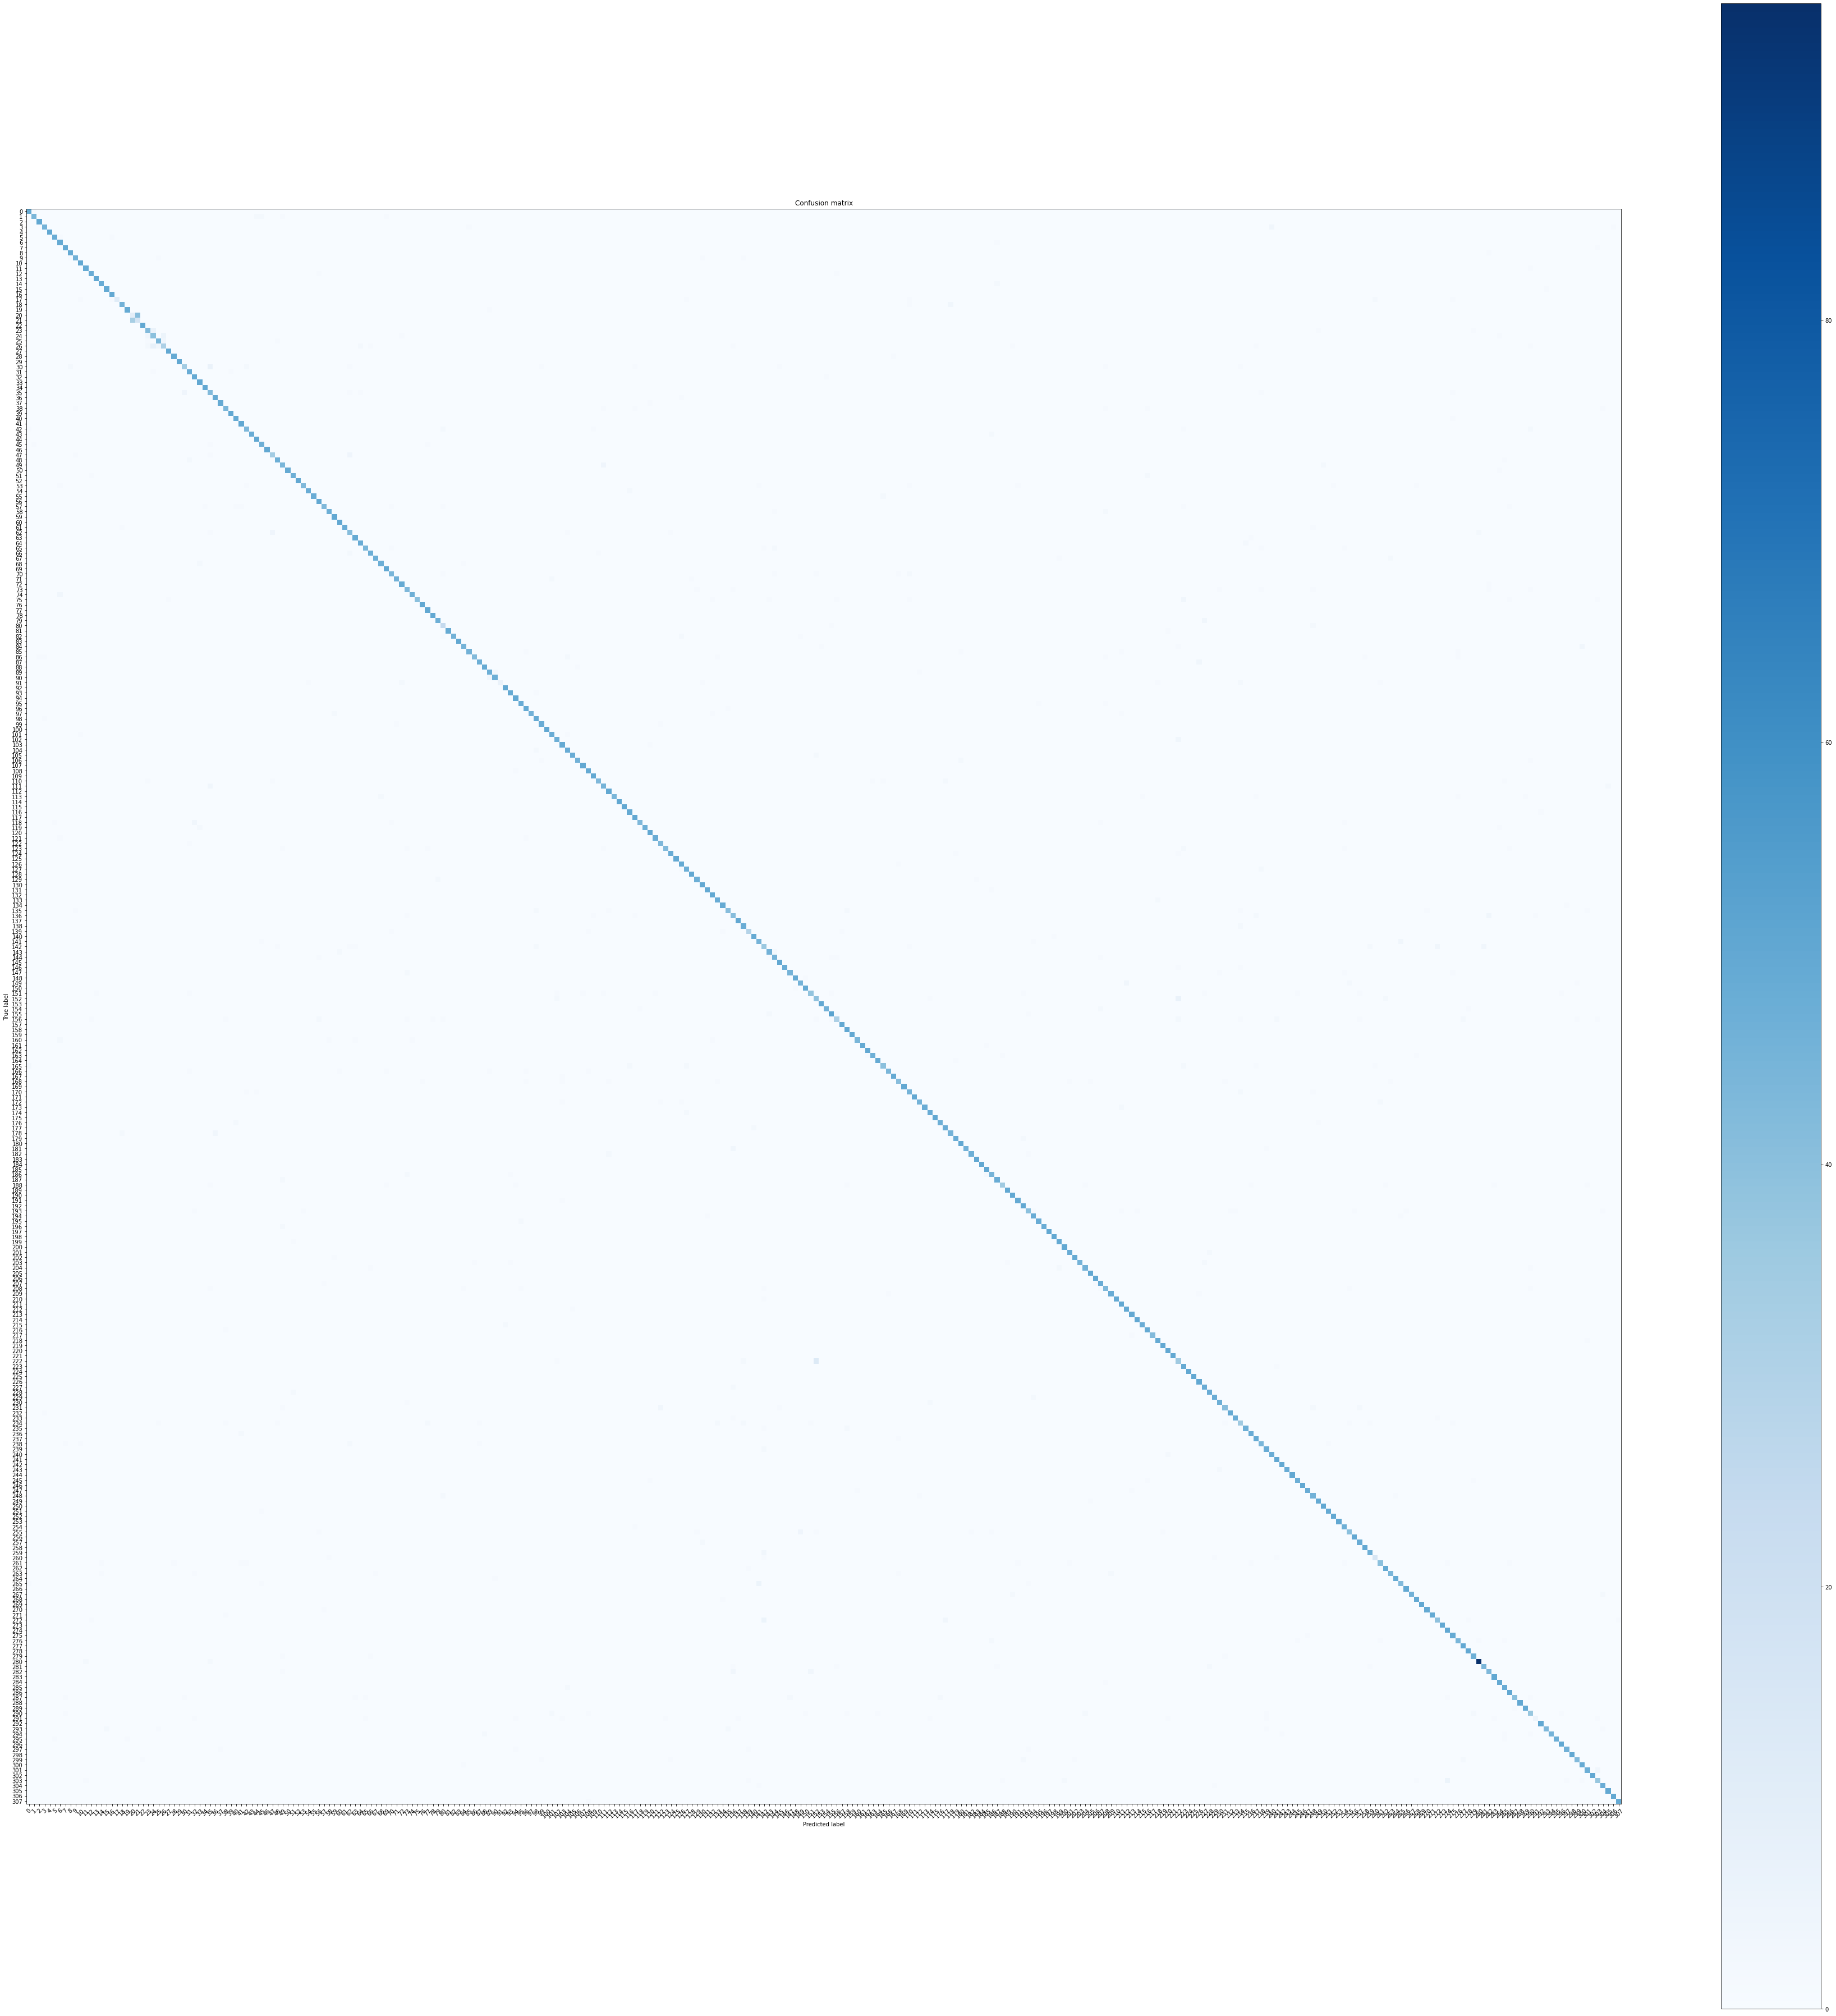

In [77]:
np.set_printoptions(precision=1)
# Plot normalized confusion matrix
plt.figure(figsize=(50, 50))
plot_confusion_matrix(cnf_matrix, classes=np.arange(cnf_matrix.shape[0]), normalize=False,
                      title="Confusion matrix")
# plt.savefig("./conf_matrix.eps", dpi=150)
plt.show()

17 Beef_Rendang_(rendang)


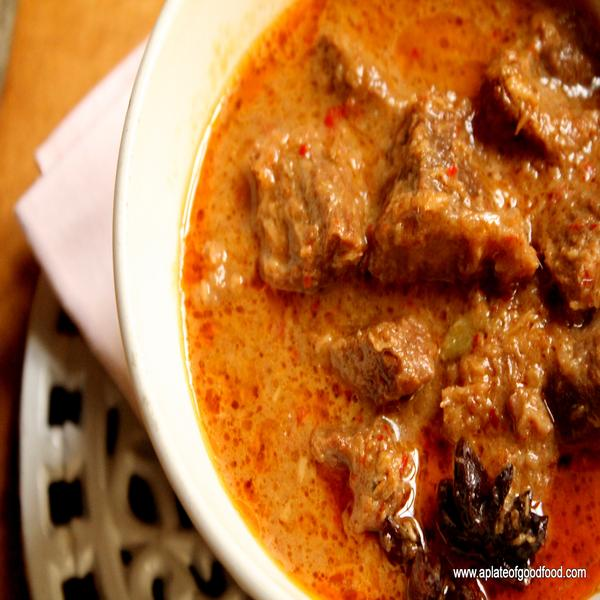

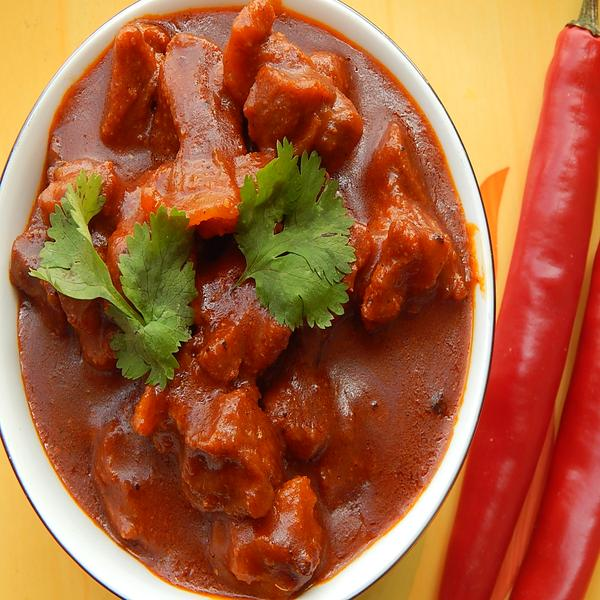

20 Beignet


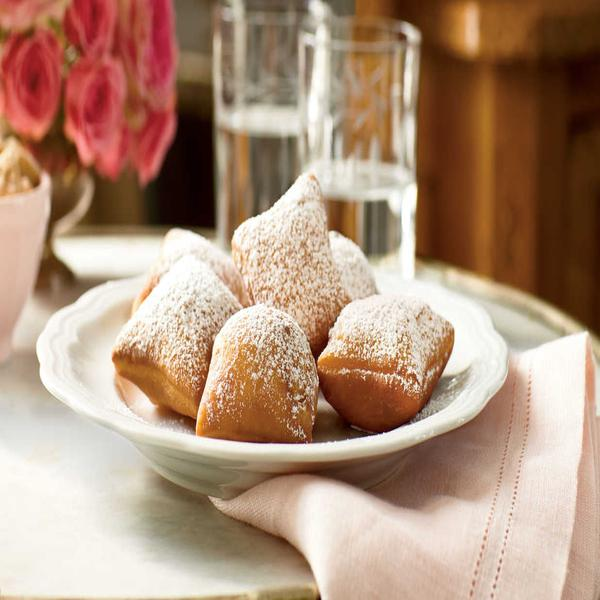

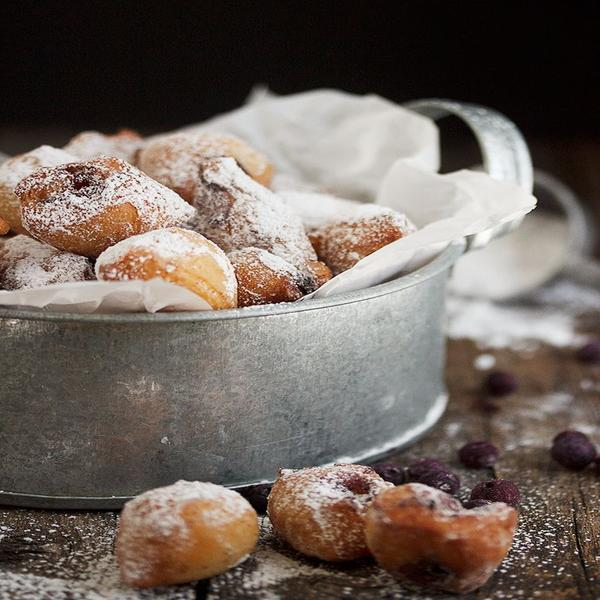

21 Beignets


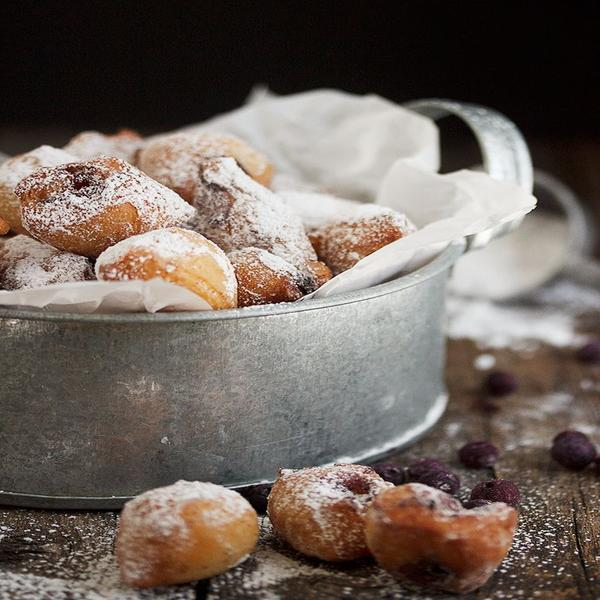

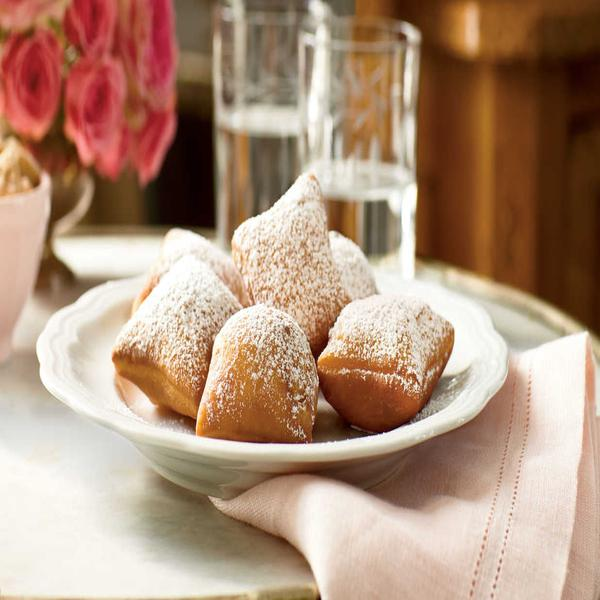

26 Bocadillo_de_queso


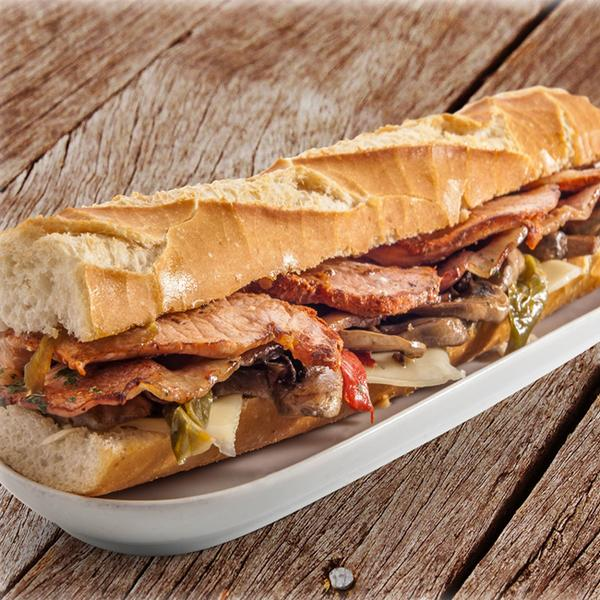

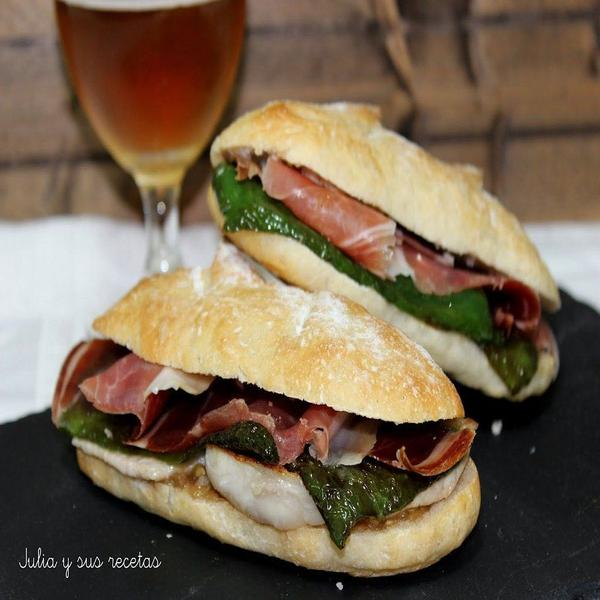

30 Breakfast_Burrito


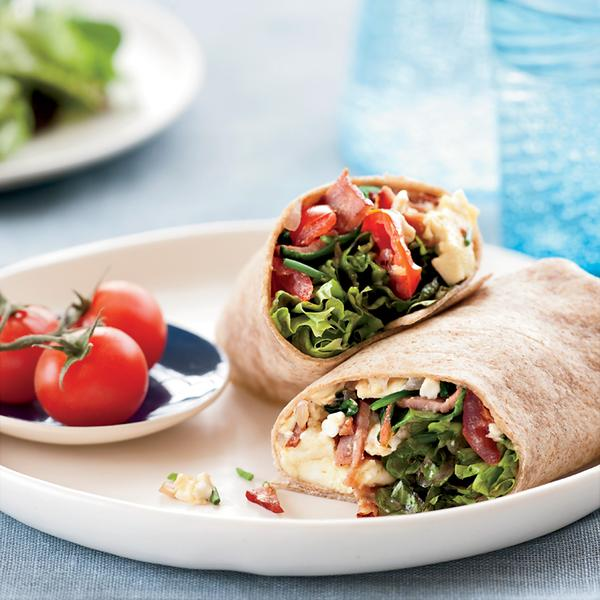

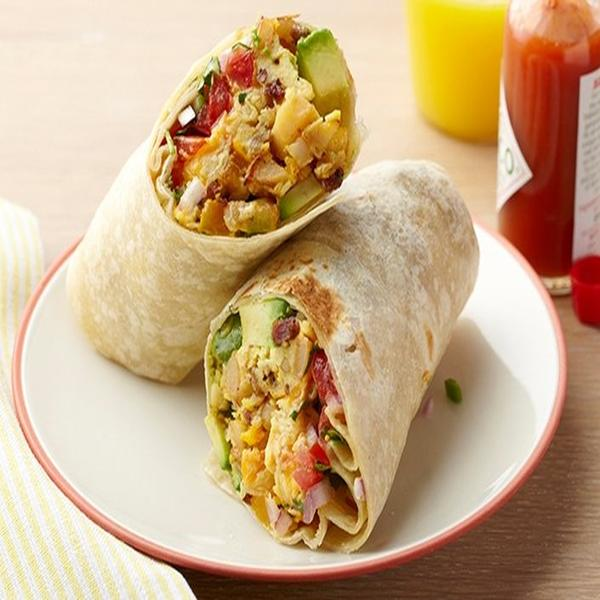

47 Cheese_Dog


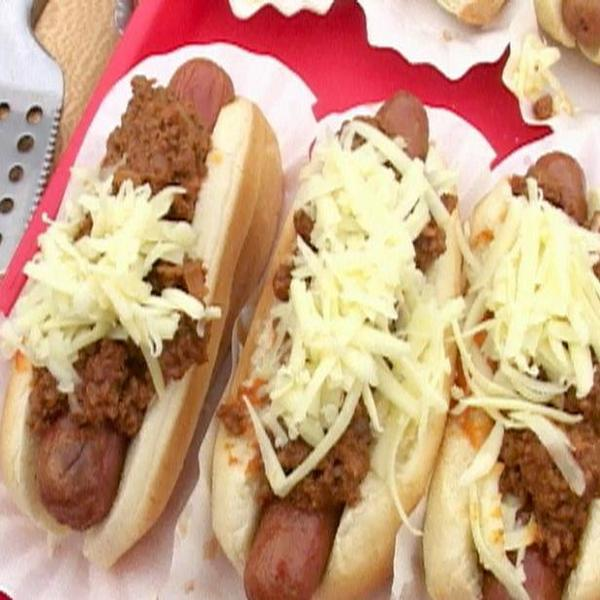

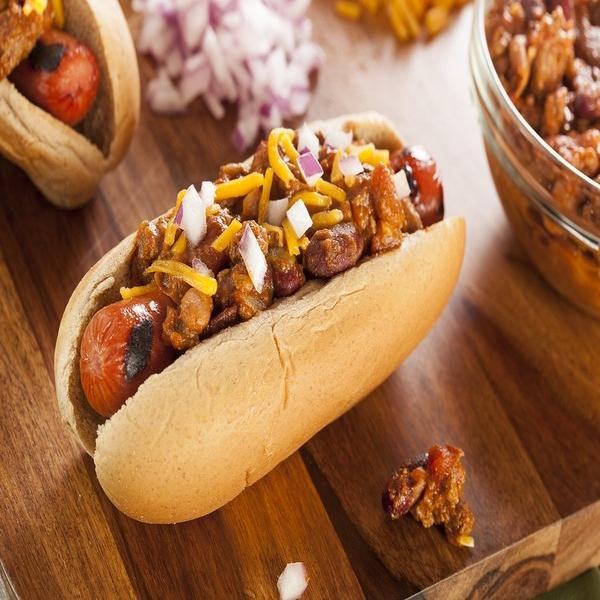

80 Couscous


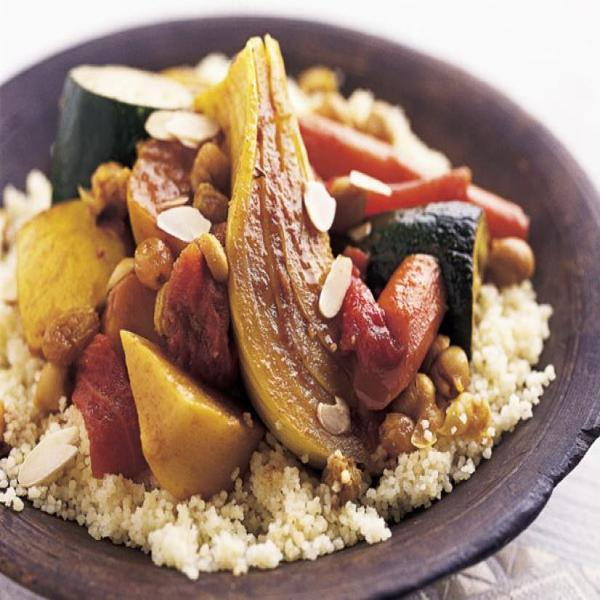

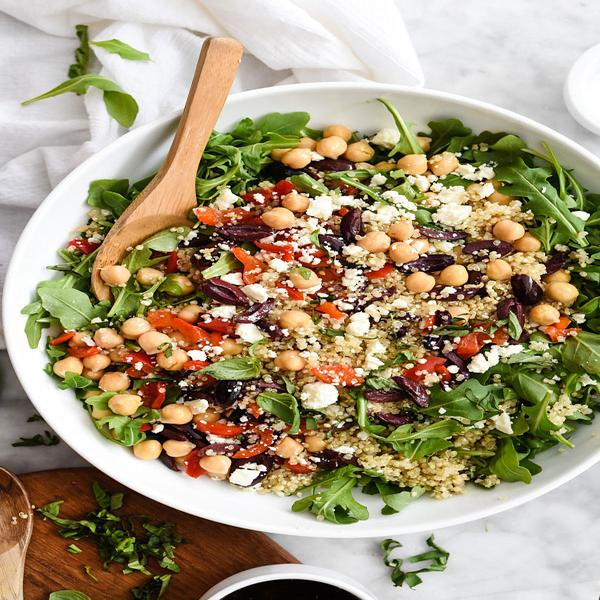

91 Cuban_Sandwich


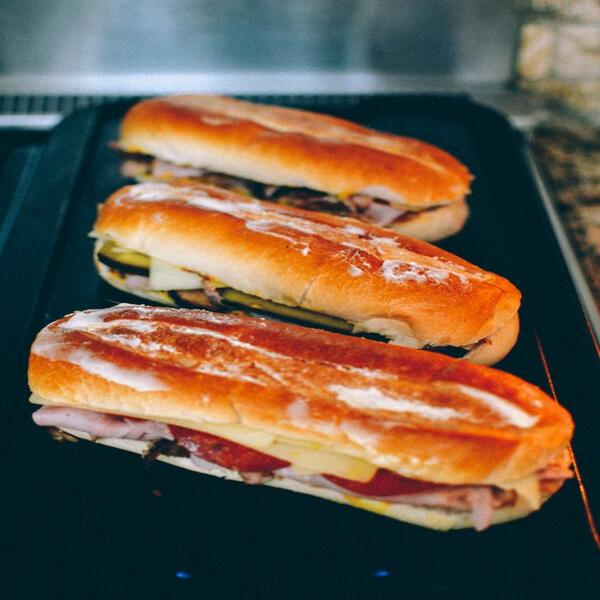

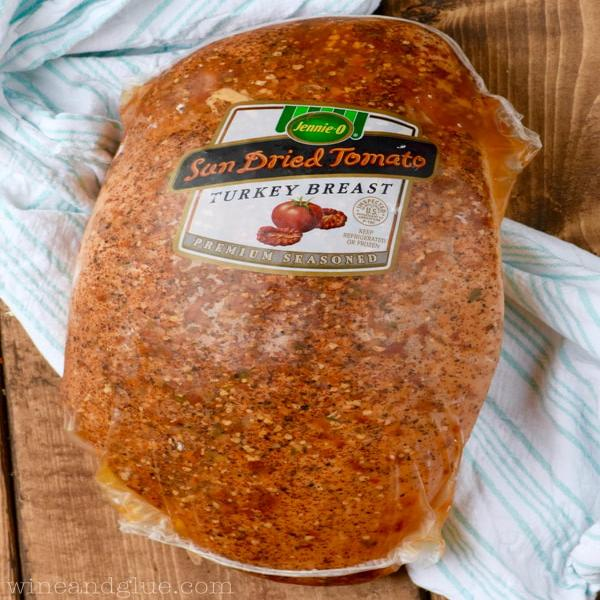

139 Houtou_Fudou


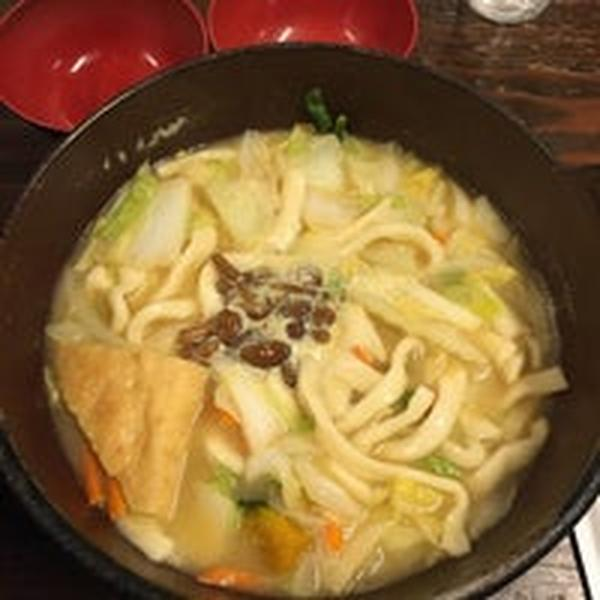

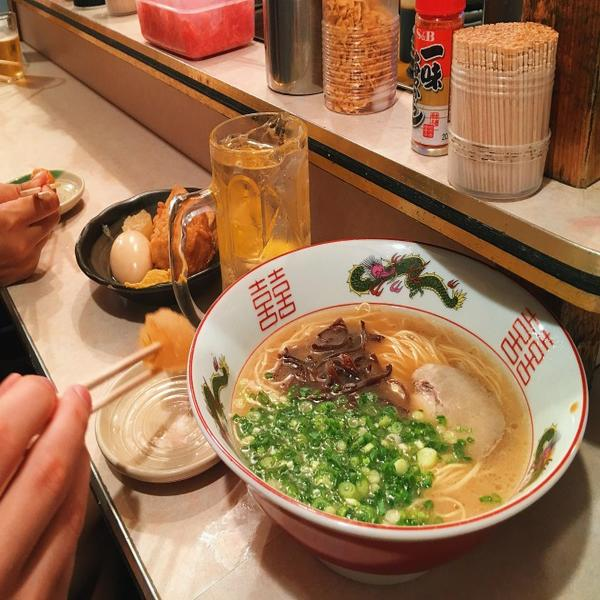

156 Italian_Style_Chicken_Mozzarella_Skillet


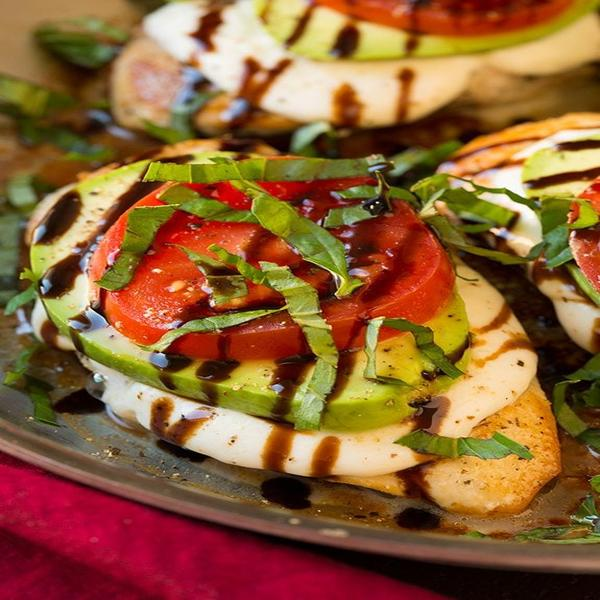

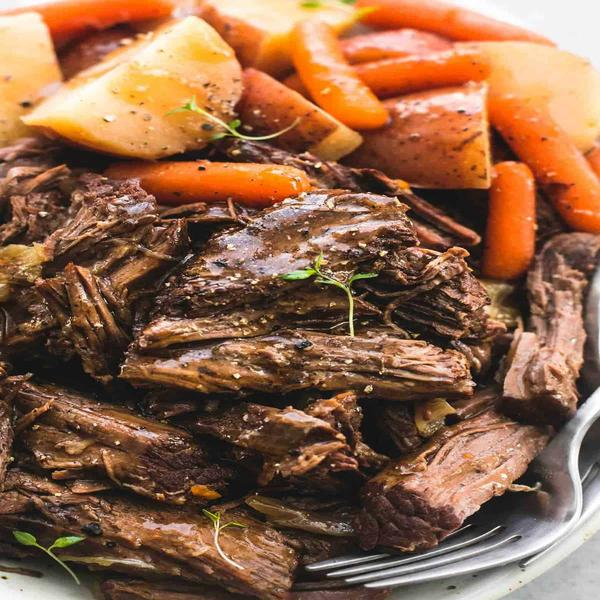

188 Maisen


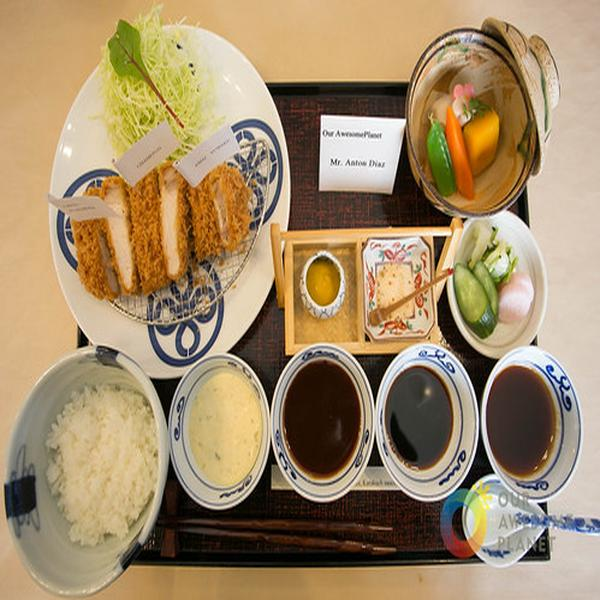

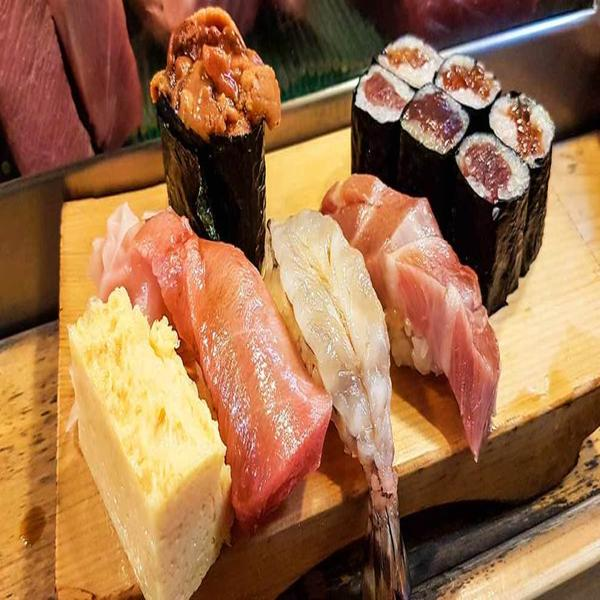

222 Orzo_With_Italian_Sausage_And_Peppers


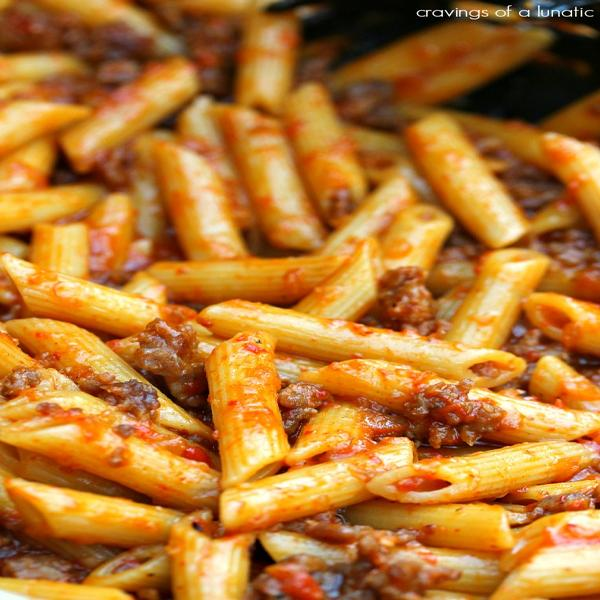

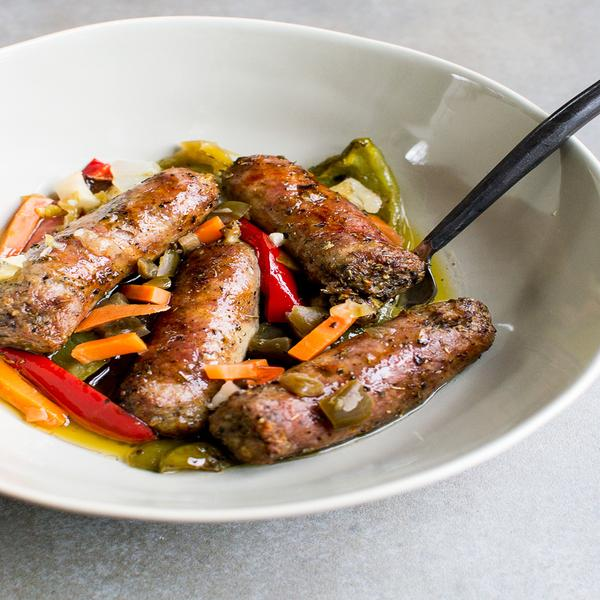

234 Pesto_Sliders


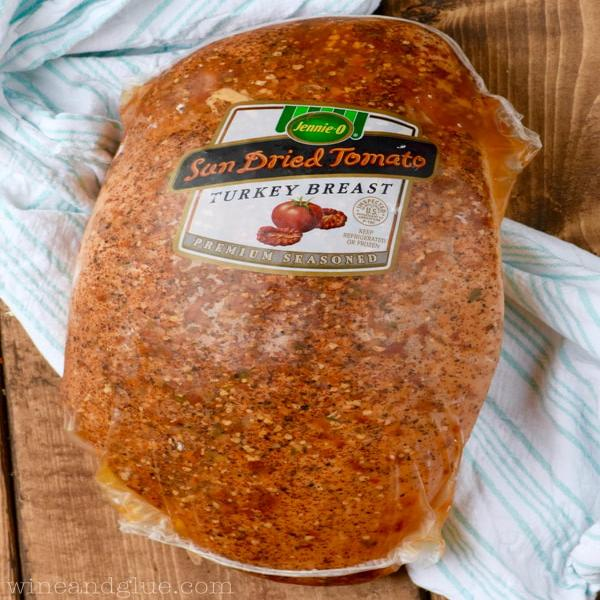

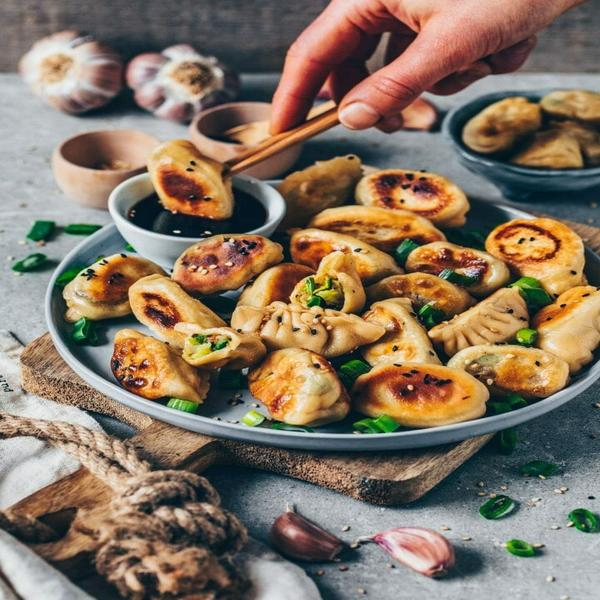

260 Rogan_Josh


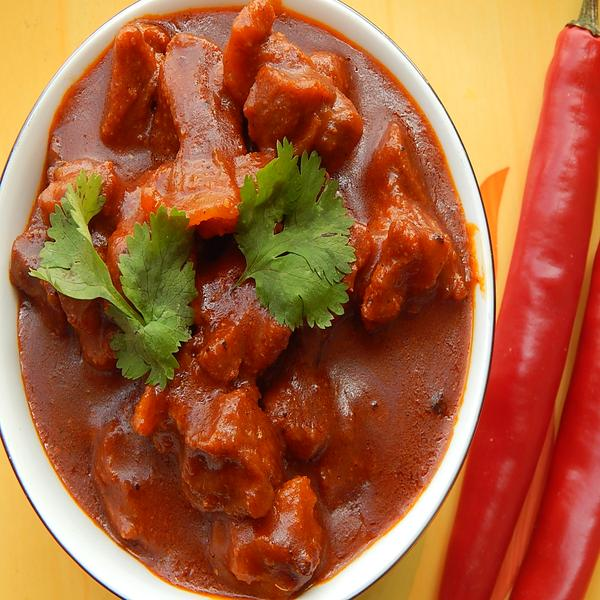

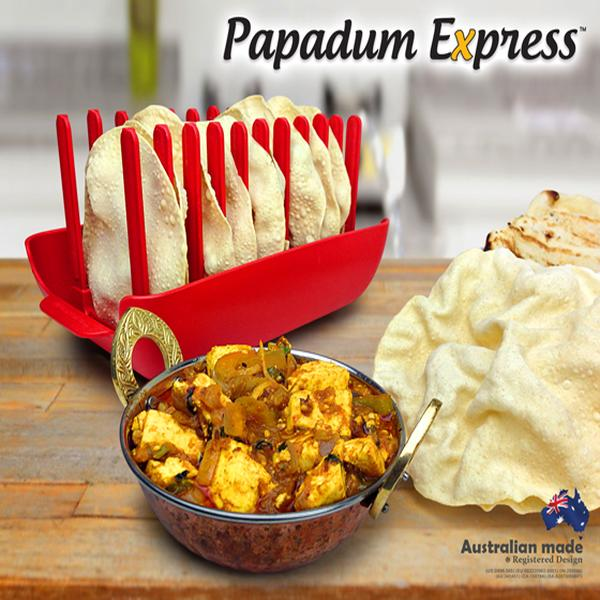

291 Teppanyaki


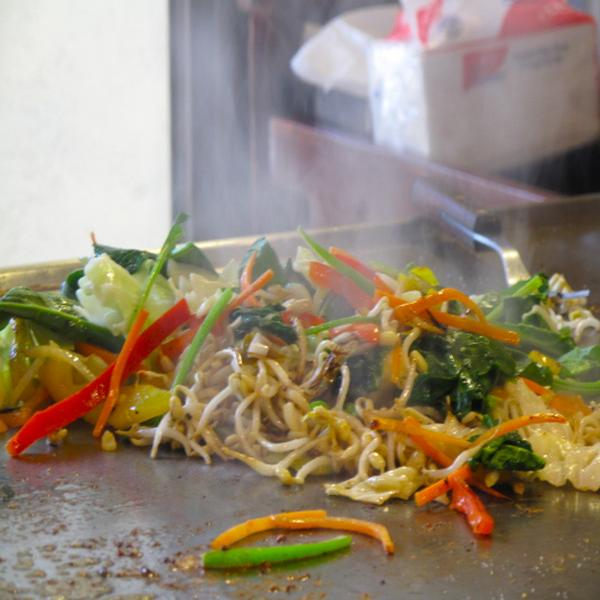

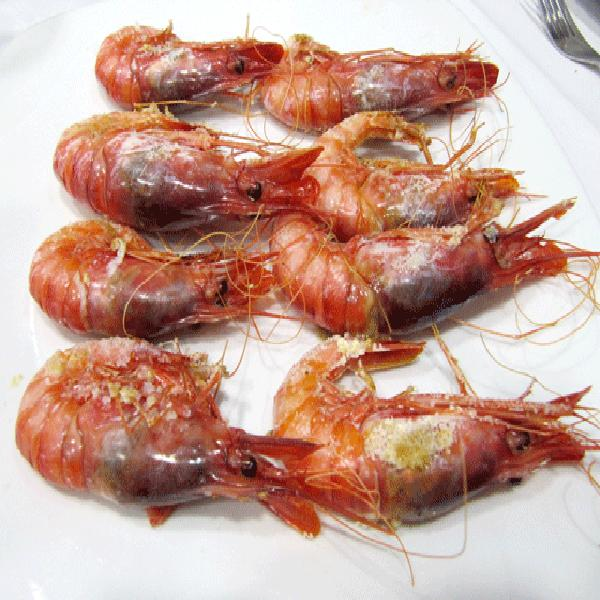

In [88]:
# каждого класса в тесте по 50 сэмплов

for i in range(cnf_matrix.shape[0]):
    if (cnf_matrix[i, i]) <= 35:
        print(i, num_to_class[i])
        get_examples_of_food(i)
        for ind_name in cnf_matrix[i, :].argsort()[-2:][::-1]:
            if ind_name != i:
                get_examples_of_food(ind_name)